In [2]:

root_dir = '/home/arm/Downloads/PCB/'  #make a folder that will contain your PCB_Dataset from kaggle

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import shutil
import random
import xml.etree.ElementTree as ET
import yaml
from pathlib import Path
from collections import Counter

from ultralytics import YOLO
from sklearn.model_selection import KFold

# Explore Dataset

In [5]:
dataset_dir = os.path.join(root_dir, 'PCB_DATASET')

for root, dirs, files in os.walk(dataset_dir):
   for name in dirs:
      print(os.path.join(root, name)) #verify all the files from Kaggle dataset

/home/arm/Downloads/PCB/PCB_DATASET/output
/home/arm/Downloads/PCB/PCB_DATASET/rotation
/home/arm/Downloads/PCB/PCB_DATASET/PCB_USED
/home/arm/Downloads/PCB/PCB_DATASET/images
/home/arm/Downloads/PCB/PCB_DATASET/images_resized
/home/arm/Downloads/PCB/PCB_DATASET/Annotations
/home/arm/Downloads/PCB/PCB_DATASET/output/images
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval
/home/arm/Downloads/PCB/PCB_DATASET/output/labels
/home/arm/Downloads/PCB/PCB_DATASET/output/images/test
/home/arm/Downloads/PCB/PCB_DATASET/output/images/val
/home/arm/Downloads/PCB/PCB_DATASET/output/images/train
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval/split_3
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval/split_2
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval/split_1
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval/split_3/val
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval/split_3/train
/home/arm/Downloads/PCB/PCB_DATASET/output/3fold_crossval/spli

In [6]:
def count_files_in_folder(folder_path):
    # Get list of all files in the folder
    files = os.listdir(folder_path)

    # Count the number of files
    num_files = len(files)

    return num_files

In [7]:
subfolders = ['Missing_hole', 'Mouse_bite', 'Open_circuit', 'Short', 'Spur', 'Spurious_copper']

images_dir = os.path.join(dataset_dir, 'images')
annot_dir = os.path.join(dataset_dir, 'Annotations')

for subfolder in subfolders:
    images_path = os.path.join(images_dir, subfolder)
    annot_path = os.path.join(annot_dir, subfolder)

    print(f'{subfolder:<15} \t\
            {count_files_in_folder(images_path)} images \t\
            {count_files_in_folder(annot_path)} annotations')

Missing_hole    	            115 images 	            115 annotations
Mouse_bite      	            115 images 	            115 annotations
Open_circuit    	            116 images 	            116 annotations
Short           	            116 images 	            116 annotations
Spur            	            115 images 	            115 annotations
Spurious_copper 	            116 images 	            116 annotations


# Create annotaton dataset

In [8]:
def parse_xml(xml_file):
    # Parse the given XML annotation file (e.g., from Pascal VOC format)
    tree = ET.parse(xml_file)       # Load and parse the XML file
    root = tree.getroot()           # Get the root element of the XML tree
    data = []                       # List to store extracted annotation data

    # Extract basic image information
    filename = root.find('filename').text       # Image file name
    width = int(root.find('size/width').text)   # Image width
    height = int(root.find('size/height').text) # Image height

    # Loop through each object (defect/label) in the XML file
    for obj in root.findall('object'):
        name = obj.find('name').text                            # Object class name
        xmin = int(obj.find('bndbox/xmin').text)                # Bounding box left (x)
        ymin = int(obj.find('bndbox/ymin').text)                # Bounding box top (y)
        xmax = int(obj.find('bndbox/xmax').text)                # Bounding box right (x)
        ymax = int(obj.find('bndbox/ymax').text)                # Bounding box bottom (y)

        # Store all details for this object in a dictionary
        data.append({
            'filename': filename,
            'width': width,
            'height': height,
            'class': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return data  # Return the list of all extracted objects


In [9]:
# List to store parsed data from all XML files
all_data = []

# Recursively traverse subdirectories
for root, dirs, files in os.walk(annot_dir):
    for name in files:
        if name.endswith('.xml'):
            xml_path = os.path.join(root, name)
            all_data.extend(parse_xml(xml_path))

In [10]:
# Create DataFrame from the parsed data
annot_df = pd.DataFrame(all_data)
annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,04_spurious_copper_17.jpg,3056,2464,spurious_copper,1163,1862,1209,1975
1,04_spurious_copper_17.jpg,3056,2464,spurious_copper,2362,1011,2457,1074
2,04_spurious_copper_17.jpg,3056,2464,spurious_copper,2423,1756,2548,1792
3,08_spurious_copper_04.jpg,2759,2154,spurious_copper,1763,962,1896,1018
4,08_spurious_copper_04.jpg,2759,2154,spurious_copper,2041,1051,2100,1138


# Visualization

In [11]:
def get_subfolder(image_name):
    if 'missing' in image_name.split('_'):
        return 'Missing_hole'
    if 'mouse' in image_name.split('_'):
        return'Mouse_bite'
    if 'open' in image_name.split('_'):
        return 'Open_circuit'
    if 'short' in image_name.split('_'):
        return 'Short'
    if 'spur' in image_name.split('_'):
        return 'Spur'
    if 'spurious' in image_name.split('_'):
        return 'Spurious_copper'

In [12]:
def visualize_annotations(image_name, images_dir, annot_df, is_subfolder=False):
    # Construct path for image
    if is_subfolder:
        image_path = os.path.join(images_dir, get_subfolder(image_name), image_name)
    else:
        image_path = os.path.join(images_dir, image_name)


    # Read image
    image = cv2.imread(image_path)

    # Filter annotations for the current image
    annotations = annot_df[annot_df['filename'] == image_name]

    # Draw bounding boxes on the image
    for _, annot in annotations.iterrows():
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']
        class_label = annot['class']

        # Check if confidence column exists
        confidence = annot.get('confidence')
        if confidence is not None:
            class_label += f" ({confidence:.2f})"

        color = (255, 255, 255)
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 3)

        # Add background to the text
        text_size = cv2.getTextSize(class_label, cv2.FONT_HERSHEY_SIMPLEX, 1.5, 2)[0]
        cv2.rectangle(image, (xmin, ymin - text_size[1] - 5),
                             (xmin + text_size[0], ymin - 1), color, -1)

        # Add text
        cv2.putText(image, class_label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 0), 2)

    # Convert BGR image to RGB (Matplotlib expects RGB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image with annotations
    plt.figure(figsize=(18, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Annotations')
    plt.text(10, image_rgb.shape[0] + 100, f'Image: {image_name}',
             color='black', fontsize=11, ha='left')
    plt.show()

    return image


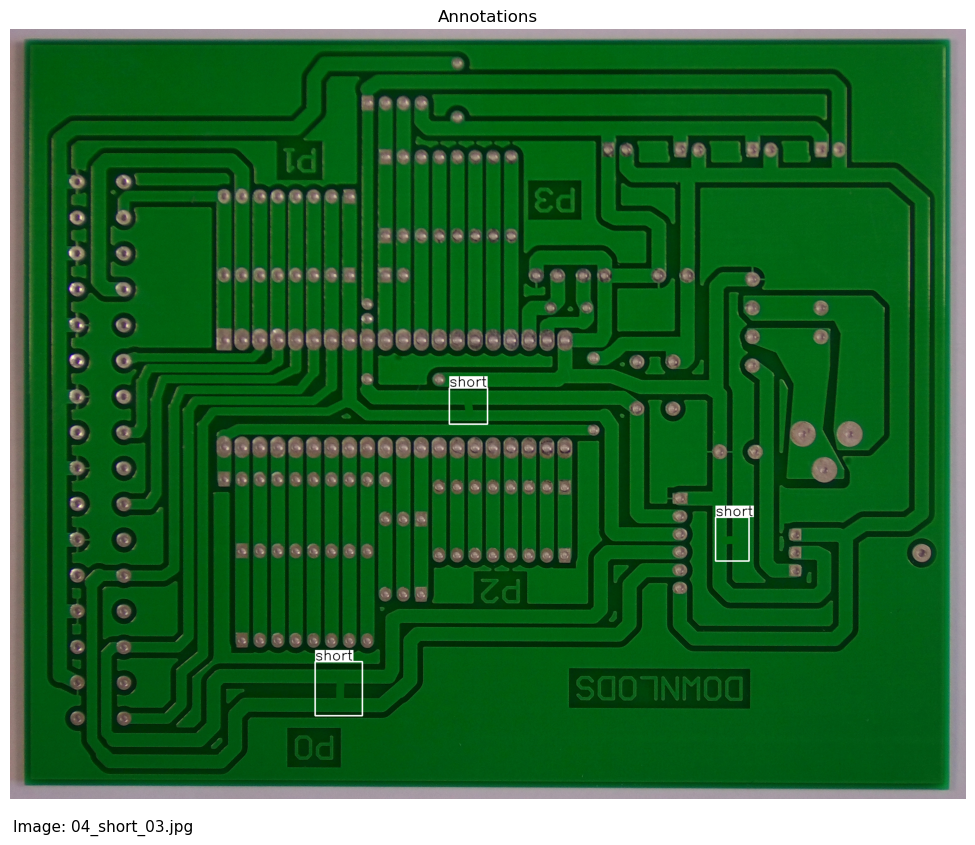

In [13]:
image_name = '04_short_03.jpg'
visualize_annotations(image_name, images_dir, annot_df, is_subfolder=True);

# Dataset preprocessing

In [14]:
def resize_images(input_dir, output_dir, target_size=(640, 640)):
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Traverse through the subfolders in the input folder
    for root, _, files in os.walk(input_dir):
        for file in files:
            # Check if the file is an image
            if file.lower().endswith(('.jpg')):
                # Read the image
                image_path = os.path.join(root, file)
                image = cv2.imread(image_path)

                # Resize the image
                resized_image = cv2.resize(image, target_size)

                # Save the resized image to the output folder
                output_path = os.path.join(output_dir, file)
                cv2.imwrite(output_path, resized_image)

resized_img_dir = os.path.join(dataset_dir, 'images_resized')
resize_images(images_dir, resized_img_dir)

In [15]:
def resize_annotations(annot_df, target_size=(640, 640)):
    all_data = []

    # Iterate through the annotation DataFrame
    for index, row in annot_df.iterrows():

        # Resize the bounding box coordinates
        width_ratio = target_size[0] / row['width']
        height_ratio = target_size[1] / row['height']

        resized_xmin = int(row['xmin'] * width_ratio)
        resized_ymin = int(row['ymin'] * height_ratio)
        resized_xmax = int(row['xmax'] * width_ratio)
        resized_ymax = int(row['ymax'] * height_ratio)

        # Update the all data list with resized annotations
        all_data.append({
            'filename': row['filename'],
            'width': target_size[0],
            'height': target_size[1],
            'class': row['class'],
            'xmin': resized_xmin,
            'ymin': resized_ymin,
            'xmax': resized_xmax,
            'ymax': resized_ymax
        })

    annot_df_resized = pd.DataFrame(all_data)
    return annot_df_resized

annot_df_resized = resize_annotations(annot_df)
annot_df_resized.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,04_spurious_copper_17.jpg,640,640,spurious_copper,243,483,253,512
1,04_spurious_copper_17.jpg,640,640,spurious_copper,494,262,514,278
2,04_spurious_copper_17.jpg,640,640,spurious_copper,507,456,533,465
3,08_spurious_copper_04.jpg,640,640,spurious_copper,408,285,439,302
4,08_spurious_copper_04.jpg,640,640,spurious_copper,473,312,487,338


# Split dataset

In [16]:
# Create the output directory
output_dir = os.path.join(dataset_dir, 'output')
os.makedirs(output_dir, exist_ok=True)

In [17]:
# Convert annotation DataFrame into YOLO labels
# YOLO format: <class_index> <x_center> <y_center> <width> <height>
def convert_to_yolo_labels(annotation_df, classes, target_size=(640, 640)):
    yolo_labels = []

    for _, annot in annotation_df.iterrows():
        filename = annot['filename']
        width, height = annot['width'], annot['height']
        class_name = annot['class']
        xmin, ymin, xmax, ymax = annot['xmin'], annot['ymin'], annot['xmax'], annot['ymax']

        # Convert bounding box coordinates to YOLO format
        x_center = (xmin + xmax) / (2 * width)
        y_center = (ymin + ymax) / (2 * height)
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height

        class_index = classes.index(class_name)

        # Append to YOLO labels list
        yolo_labels.append((filename, class_index, x_center, y_center, bbox_width, bbox_height))

    return yolo_labels


classes = ['missing_hole', 'mouse_bite', 'open_circuit',
           'short', 'spur', 'spurious_copper']
yolo_labels = convert_to_yolo_labels(annot_df_resized, classes)


In [18]:
def split_images_and_labels(images_dir, labels, output_dir, train_split=0.95, val_split=0.05):
    # os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images/test'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/val'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels/test'), exist_ok=True)

    # Group labels by image filename
    image_labels = {}
    for label in labels:
        filename, class_index, x_center, y_center, bbox_width, bbox_height = label
        if filename not in image_labels:
            image_labels[filename] = []
        image_labels[filename].append(label)

    # Shuffle the image filenames
    image_filenames = list(image_labels.keys())
    random.shuffle(image_filenames)

    # Split the dataset
    num_images = len(image_filenames)
    num_train = int(num_images * train_split)
    num_val = int(num_images * val_split)

    train_filenames = image_filenames[:num_train]
    val_filenames = image_filenames[num_train:num_train + num_val]
    test_filenames = image_filenames[num_train + num_val:]

    # Write train, val, test images and labels
    for dataset, filenames in [('train', train_filenames), ('val', val_filenames), ('test', test_filenames)]:
        for filename in filenames:
            labels = image_labels[filename]
            with open(os.path.join(output_dir, f'labels/{dataset}/{os.path.splitext(filename)[0]}.txt'), 'a') as label_file:
                for label in labels:
                    _, class_index, x_center, y_center, bbox_width, bbox_height = label
                    label_file.write(f"{class_index} {x_center} {y_center} {bbox_width} {bbox_height}\n")
            # Copy images to corresponding folders
            shutil.copy(os.path.join(images_dir, filename), os.path.join(output_dir, f'images/{dataset}/{filename}'))

split_images_and_labels(resized_img_dir, yolo_labels, output_dir)

# K-Fold Cross Validation

In [19]:
dataset_path = Path(output_dir)
labels = sorted(dataset_path.rglob("*labels/train/*.txt")) # all data in 'labels'

In [20]:
cls_idx = list(range(len(classes)))
print(list(zip(classes, cls_idx)))

[('missing_hole', 0), ('mouse_bite', 1), ('open_circuit', 2), ('short', 3), ('spur', 4), ('spurious_copper', 5)]


In [21]:
indx = [l.stem for l in labels] # uses base filename as ID (no extension)
labels_df = pd.DataFrame([], columns=cls_idx, index=indx)

In [22]:
for label in labels:
    lbl_counter = Counter()

    with open(label,'r') as lf:
        lines = lf.readlines()

    for l in lines:
        # classes for YOLO label uses integer at first position of each line
        lbl_counter[int(l.split(' ')[0])] += 1

    labels_df.loc[label.stem] = lbl_counter

labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`
labels_df.head()

/tmp/ipykernel_14655/2627102905.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  labels_df = labels_df.fillna(0.0) # replace `nan` values with `0.0`


,0,1,2,3,4,5
01_missing_hole_01,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_02,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_03,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_04,6.0,0.0,0.0,0.0,0.0,0.0
01_missing_hole_05,8.0,0.0,0.0,0.0,0.0,0.0


In [23]:
ksplit = 3
kf = KFold(n_splits=ksplit, shuffle=True, random_state=20)   # setting random_state for repeatable results

kfolds = list(kf.split(labels_df))

In [24]:
folds = [f'split_{n}' for n in range(1, ksplit + 1)]
folds_df = pd.DataFrame(index=indx, columns=folds)

for idx, (train, val) in enumerate(kfolds, start=1):
    folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
    folds_df[f'split_{idx}'].loc[labels_df.iloc[val].index] = 'val'

/tmp/ipykernel_14655/3825890032.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  folds_df[f'split_{idx}'].loc[labels_df.iloc[train].index] = 'train'
/tmp/ipykernel_14655/3825890032.py:6: FutureWarning: ChainedAssignmentError: behaviour wi

In [25]:
fold_lbl_distrb = pd.DataFrame(index=folds, columns=cls_idx)

for n, (train_indices, val_indices) in enumerate(kfolds, start=1):
    train_totals = labels_df.iloc[train_indices].sum()
    val_totals = labels_df.iloc[val_indices].sum()

    # To avoid division by zero, we add a small value (1E-7) to the denominator
    ratio = val_totals / (train_totals + 1E-7)
    fold_lbl_distrb.loc[f'split_{n}'] = ratio

fold_lbl_distrb

,0,1,2,3,4,5
split_1,0.48913,0.464567,0.500816,0.47182,0.510433,0.568595
split_2,0.569558,0.576271,0.538462,0.4624,0.500797,0.464506
split_3,0.446456,0.464567,0.462639,0.570447,0.488924,0.471318


In [26]:
# Initialize a list to store image file paths
images = sorted(dataset_path.rglob("*images/train/*.jpg"))

# Create the necessary directories and dataset YAML files (unchanged)
save_path = Path(dataset_path / f'{ksplit}fold_crossval')
save_path.mkdir(parents=True, exist_ok=True)
ds_yamls = []

for split in folds_df.columns:
    # Create directories
    split_dir = save_path / split
    split_dir.mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'train' / 'labels').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'images').mkdir(parents=True, exist_ok=True)
    (split_dir / 'val' / 'labels').mkdir(parents=True, exist_ok=True)

    # Create dataset YAML files
    dataset_yaml = split_dir / f'{split}_dataset.yaml'
    ds_yamls.append(dataset_yaml)

    with open(dataset_yaml, 'w') as ds_y:
        yaml.safe_dump({
            'path': split_dir.as_posix(),
            'train': 'train',
            'val': 'val',
            'names': classes
        }, ds_y)

In [27]:
for image, label in zip(images, labels):
    for split, k_split in folds_df.loc[image.stem].items():
        # Destination directory
        img_to_path = save_path / split / k_split / 'images'
        lbl_to_path = save_path / split / k_split / 'labels'

        # Copy image and label files to new directory
        shutil.copy(image, img_to_path / image.name)
        shutil.copy(label, lbl_to_path / label.name)

In [28]:
folds_df.to_csv(save_path / "kfold_datasplit.csv")
fold_lbl_distrb.to_csv(save_path / "kfold_label_distribution.csv")

# Model Training

In [ ]:
model = YOLO('yolov8n.pt')   # nano version only

batch = 2                    # keep extremely small
imgsz = 416                  # smaller input
epochs = 10                  # shorter run for testing
mixup = 0.0
save_period = 5
verbose = True
project = 'pcb_ultra_light'
results={}

for k in range(ksplit):
    dataset_yaml = ds_yamls[k]
    model.train(
        data=dataset_yaml,
        epochs=epochs,
        batch=batch,
        imgsz=imgsz,
        lr0=0.001,
        lrf=0.0001,
        save_period=save_period,
        verbose=verbose,
        project=project,
        device=0,
        workers=1,
        cache=False,
        amp=False   # disable mixed precision (saves VRAM on small GPUs)
    )
    results[k] = model.metrics


# Model

In [35]:
import torch, gc, os
gc.collect()
torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Use the nano model instead of small (s)
model = YOLO('yolov8n.pt')

# Light configuration for 4 GB GPU
batch = 2                # ↓ 16 → 2
imgsz = 416              # ↓ 640 → 416
epochs = 10              # ↓ 180 → 80 (you can increase later)
mixup = 0.0              # Disable heavy augmentations
save_period = 5          # Saves every 5 epochs to reduce disk writes
verbose = True
project = 'pcb_light'

# Your dataset YAML
all_data_yaml = f"""
path: {output_dir}
train: images/train
val: images/val

names:
    0: missing_hole
    1: mouse_bite
    2: open_circuit
    3: short
    4: spur
    5: spurious_copper
"""

data_path = os.path.join(root_dir, 'data.yaml')
with open(data_path, 'w') as f:
    f.write(all_data_yaml)

# Train
result = model.train(
    data=data_path,
    epochs=epochs,
    batch=batch,
    imgsz=imgsz,
    lr0=0.001,
    lrf=0.0001,
    save_period=save_period,
    verbose=verbose,
    project=project,
    device=0,
    workers=1,
    cache=False,
    amp=False       # disables mixed precision → fewer VRAM spikes
)


Ultralytics 8.3.224 🚀 Python-3.11.9 torch-2.9.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3050 Ti Laptop GPU, 3769MiB)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/arm/Downloads/PCB/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.0001, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

train: New cache created: /home/arm/Downloads/PCB/PCB_DATASET/output/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1064.2±833.7 MB/s, size: 151.3 KB)
val: Scanning /home/arm/Downloads/PCB/PCB_DATASET/output/labels/val... 65 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 65/65 3.1Kit/s 0.0s
val: /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/06_mouse_bite_07.jpg: 5 duplicate labels removed
val: /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/07_mouse_bite_04.jpg: 5 duplicate labels removed
val: /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/10_spurious_copper_02.jpg: 5 duplicate labels removed
val: New cache created: /home/arm/Downloads/PCB/PCB_DATASET/output/labels/val.cache
Plotting labels to /home/arm/Downloads/PCB/pcb_light/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) wi

In [39]:
results_dir = '//home/arm/Downloads/PCB/pcb_light/train3'
dest_results_dir = os.path.join(root_dir, 'results')

shutil.copytree(results_dir, dest_results_dir)

'/home/arm/Downloads/PCB/results'

In [40]:
results_df = pd.read_csv(os.path.join(dest_results_dir, 'results.csv'))
results_df.columns = results_df.columns.str.strip()
results_df = results_df.apply(pd.to_numeric, errors='coerce').dropna()
results_df.head()

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,9.28969,3.66246,7.27226,1.35394,0.00020,0.02857,0.00016,0.00005,3.72804,6.25586,1.21091,0.000332,0.000332,0.000332
1,2,18.50730,3.53652,5.47392,1.20828,0.05046,0.07786,0.03106,0.00825,3.28491,5.18685,1.11686,0.000599,0.000599,0.000599
2,3,27.69620,3.26800,4.66159,1.13307,0.44448,0.14293,0.14833,0.04726,3.08078,4.45465,1.07181,0.000799,0.000799,0.000799
3,4,36.89290,3.09895,4.28763,1.07903,0.30971,0.25269,0.19859,0.07454,2.92688,4.14309,1.03884,0.000700,0.000700,0.000700
4,5,46.21750,2.95204,3.77660,1.05910,0.39050,0.23789,0.26043,0.08936,2.85587,3.76443,1.01812,0.000600,0.000600,0.000600


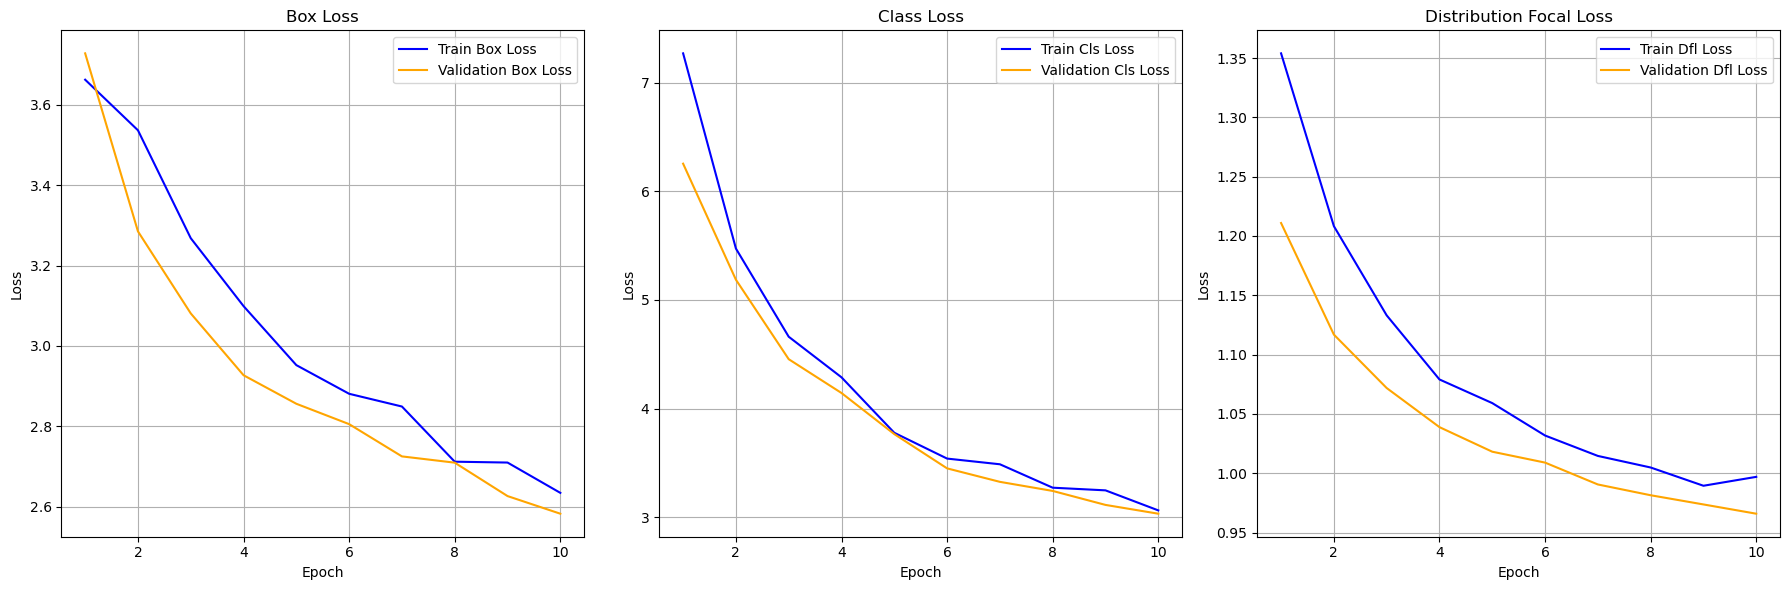

In [41]:
epochs = results_df['epoch']
train_box_loss = results_df['train/box_loss']
val_box_loss = results_df['val/box_loss']
train_cls_loss = results_df['train/cls_loss']
val_cls_loss = results_df['val/cls_loss']
train_dfl_loss = results_df['train/dfl_loss']
val_dfl_loss = results_df['val/dfl_loss']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot box loss
axs[0].plot(epochs, train_box_loss, label='Train Box Loss', color='blue')
axs[0].plot(epochs, val_box_loss, label='Validation Box Loss', color='orange')
axs[0].set_title('Box Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot cls loss
axs[1].plot(epochs, train_cls_loss, label='Train Cls Loss', color='blue')
axs[1].plot(epochs, val_cls_loss, label='Validation Cls Loss', color='orange')
axs[1].set_title('Class Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)

# Plot dfl loss
axs[2].plot(epochs, train_dfl_loss, label='Train Dfl Loss', color='blue')
axs[2].plot(epochs, val_dfl_loss, label='Validation Dfl Loss', color='orange')
axs[2].set_title('Distribution Focal Loss')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

# Predict on test data

In [51]:
best_model_path = os.path.join(dest_results_dir, 'weights/best.pt')
model = YOLO(best_model_path)

test_data_dir = os.path.join(output_dir, 'images/val')
metrics = model(source=test_data_dir, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_missing_hole_06.jpg: 640x640 1 missing_hole, 4.7ms
image 2/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_mouse_bite_01.jpg: 640x640 (no detections), 4.8ms
image 3/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_mouse_bite_05.jpg: 640x640 (no detections), 4.8ms
image 4/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_mouse_bite_10.jpg: 640x640 (no detections), 6.1ms
image 5/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_open_circuit_02.jpg: 640x640 (no detections), 10.2ms
image 6/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_open_circuit_06.jpg: 640x640 (no detections), 5.6ms
image 7/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_open_circuit_13.jpg: 640x640 (no detections), 5.7ms
image 8/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images/val/01_short_06.jpg: 640x640 1 short, 6.1ms
image 9/65 /home/arm/Downloads/PCB/PCB_DATASET/output/images

In [66]:
predict_dir = '/home/arm/Downloads/PCB/runs/detect/predict2/labels'
dest_predict_dir = os.path.join(root_dir, 'results/predict2')

shutil.copytree(predict_dir, dest_predict_dir)

'/home/arm/Downloads/PCB/results/predict2'

In [45]:
def yolo_to_original_annot(image_name, yolo_labels, annot_df, classes):
    original_annot = []

    for yolo_label in yolo_labels:
        # Extract original width and height from annotation DataFrame
        original_size = annot_df.loc[annot_df['filename'] == image_name, ['width', 'height']].iloc[0]
        original_width, original_height = original_size['width'], original_size['height']

        # Extract YOLO label components
        class_index, x_center, y_center, bbox_width, bbox_height, confidence = yolo_label

        # Scale bounding box coordinates and dimensions to original size
        original_x_center = x_center * original_width
        original_y_center = y_center * original_height
        original_bbox_width = bbox_width * original_width
        original_bbox_height = bbox_height * original_height

        # Calculate original bounding box coordinates
        original_x_min = original_x_center - original_bbox_width / 2
        original_y_min = original_y_center - original_bbox_height / 2
        original_x_max = original_x_center + original_bbox_width / 2
        original_y_max = original_y_center + original_bbox_height / 2

        # Append original annotation to list
        original_annot.append({
            'filename': image_name,
            'width': int(original_width),
            'height': int(original_height),
            'class': classes[int(class_index)],
            'xmin': int(original_x_min),
            'ymin': int(original_y_min),
            'xmax': int(original_x_max),
            'ymax': int(original_y_max),
            'confidence': confidence
        })

    return pd.DataFrame(original_annot)

In [67]:
def read_yolo_labels_from_file(file_path):
    labels = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split()
            values = [float(value) for value in values]
            labels.append(values)
    return labels

file_path = os.path.join(dest_predict_dir, '12_spurious_copper_10.txt')
yolo_labels = read_yolo_labels_from_file(file_path)
yolo_labels

[[5.0, 0.446405, 0.740144, 0.0388851, 0.0129145, 0.959115],
 [5.0, 0.715145, 0.15048, 0.0146599, 0.0363427, 0.758193],
 [5.0, 0.73267, 0.587739, 0.0160868, 0.0371663, 0.624131],
 [5.0, 0.141704, 0.653572, 0.0302333, 0.0131266, 0.557755],
 [5.0, 0.446794, 0.736465, 0.0390975, 0.0143941, 0.490232]]

In [68]:
pred_annot_df = yolo_to_original_annot('12_spurious_copper_10.jpg', yolo_labels, annot_df, classes)
pred_annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,confidence
0,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1079,1856,1178,1888,0.959115
1,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1790,334,1827,426,0.758193
2,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1832,1439,1873,1533,0.624131
3,12_spurious_copper_10.jpg,2529,2530,spurious_copper,320,1636,396,1670,0.557755
4,12_spurious_copper_10.jpg,2529,2530,spurious_copper,1080,1845,1179,1881,0.490232


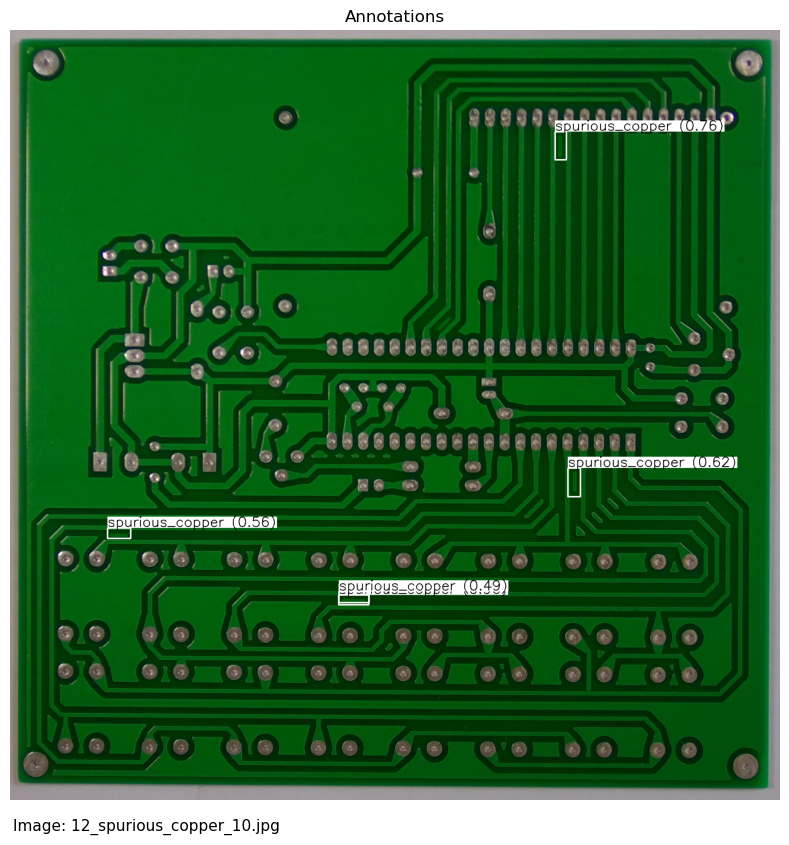

In [69]:
visualize_annotations('12_spurious_copper_10.jpg', images_dir, pred_annot_df, is_subfolder=True);

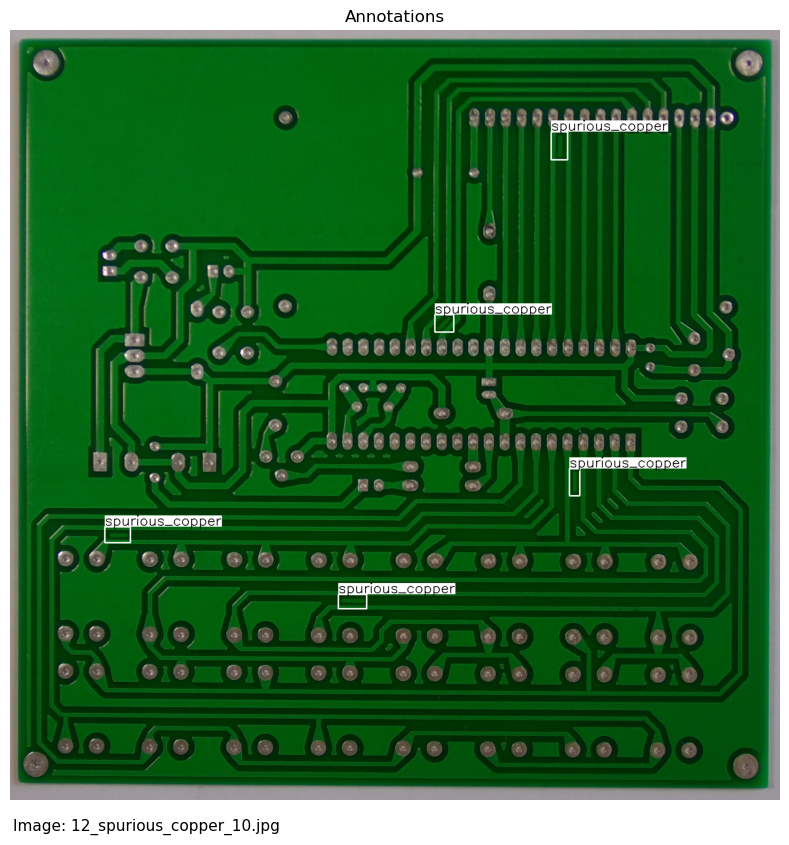

In [70]:
visualize_annotations('12_spurious_copper_10.jpg', images_dir, annot_df, is_subfolder=True);

In [71]:
model.export()

Ultralytics 8.3.224 🚀 Python-3.11.9 torch-2.9.0+cu128 CPU (12th Gen Intel Core i7-12650H)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from '/home/arm/Downloads/PCB/results/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 10, 3549) (5.9 MB)

TorchScript: starting export with torch 2.9.0+cu128...
TorchScript: export success ✅ 1.8s, saved as '/home/arm/Downloads/PCB/results/weights/best.torchscript' (11.8 MB)

Export complete (2.1s)
Results saved to /home/arm/Downloads/PCB/results/weights
Predict:         yolo predict task=detect model=/home/arm/Downloads/PCB/results/weights/best.torchscript imgsz=416  
Validate:        yolo val task=detect model=/home/arm/Downloads/PCB/results/weights/best.torchscript imgsz=416 data=/home/arm/Downloads/PCB/data.yaml  
Visualize:       https://netron.app


'/home/arm/Downloads/PCB/results/weights/best.torchscript'

In [72]:
custom_img_dir = os.path.join(root_dir, 'custom_images')
resized_custom_img_dir = os.path.join(custom_img_dir, 'resized')
resize_images(custom_img_dir, resized_custom_img_dir)

In [90]:
model = YOLO(best_model_path)

image_path = os.path.join(resized_custom_img_dir, '01.jpg')
result_custom = model(image_path, imgsz=640, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/1 /home/arm/Downloads/PCB/custom_images/resized/01.jpg: 640x640 (no detections), 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /home/arm/Downloads/PCB/runs/detect/predict
0 label saved to /home/arm/Downloads/PCB/runs/detect/predict/labels


In [93]:
predict_dir = '/home/arm/Downloads/PCB/runs/detect/predict2/labels'
dest_custom_predict_dir = os.path.join(custom_img_dir, 'results/predict2')

shutil.copytree(predict_dir, dest_custom_predict_dir)

'/home/arm/Downloads/PCB/custom_images/results/predict2'